## 4.1 누락된 데이터 다루기

### 4.1.1 테이블 형태 데이터에서 누락된 값 식별

In [2]:
import pandas as pd
from io import StringIO

csv_data = \
"""A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0, 11.0, 12.0,
"""
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
# null값 확인
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

### 4.1.2 누락된 값이 있는 훈련 샘플이나 특성 제외

In [4]:
df.dropna(axis=0) # axis=0 은 행 삭제, axis=1은 열 삭제

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
# 모든 열이 NaN일 때만 행을 삭제
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# NaN이 아닌 값이 4개보다 작은 행을 삭제
df.dropna(thresh=4) 

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# 특정 열에 NaN이 있는 행만 삭제
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### 4.1.3 누락된 값 대체 
- 보간(interpolation) 기법

In [8]:
# 평균으로 대체하는 보간 기법
# 각 특성 열의 평균으로 누락된 값 대체  

# simpleimputer 클래스는 한 특성의 통계 값을 사용하여 누락된 값을 채운다.

from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

위의 결과에서 1,2,4번째 열의 수치 총합 -> 1+5+2+6+4+8 = 24

각 열의 평균 24 / 4 = 6

-> 3번째 열의 누락값 3으로 대체

In [9]:
from sklearn.preprocessing import FunctionTransformer
ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

In [10]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

# 누락된 값의 위치 인덱스가 왜 1. , 0. 혹은 0. , 1. 으로 표현되는지? -> 대략 알 것 같음

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

In [11]:
imr.indicator_.features_

array([2, 3])

In [12]:
# 누락된 값의 위치를 나타내는 배열을 반환 -> 이 배열 값이 imr의 transform 메서드가 반환한 배열의 마지막 두 열에 해당함

imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [13]:
# 누락된 값을 대체한 배열을 원본 배열의 값으로 복원

imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [14]:
# IterativeImputer 클래스는 누락된 값이 있는 특성과 다른 특성을 사용하여 누락된 값을 예측한다. 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iimr = IterativeImputer()
iimr.fit_transform(df.values)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

In [15]:
# KNNImputer 클래스는 k-최근접 이웃 방식을 사용하여 누락된 값을 채운다.
# 샘플 개수가 n_neighbors보다 작으면 simpleimputer (strategy='mean') 과 결과가 같다.

from sklearn.impute import KNNImputer
kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [16]:
# 판다스의 fillna 메서드로 누락된 값 채우기

df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [17]:
df.fillna(method='backfill') # 누락값을 다음 행의 값으로 채운다.

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [18]:
df.fillna(method='ffill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


In [19]:
df.fillna(method='ffill', axis=1) # 누락값을 이전 열의 값으로 채운다.

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


## 4.2 범주형 데이터 다루기

범주형 데이터 
1. 순서가 있는 범주형 데이터 ex. 티셔츠의 사이즈 (XL > L)
2. 순서가 없는 범주형 데이터 ex. 색깔

In [20]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 4.2.2 순서가 있는 특성 매핑

In [21]:
# size feature의 산술적인 관계를 XL = L + 1 = M + 2 라고 가정

size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [22]:
size_mapping.items()

dict_items([('XL', 3), ('L', 2), ('M', 1)])

In [23]:
# 원래의 레이블로 복원

inv_size_mapping = {v: k  for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.3 클래스 레이블 인코딩

In [24]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [25]:
import numpy as np
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [26]:
df['classlabel'] = df['classlabel'].map(class_mapping) # map함수가 class_mapping의 키값을 찾아서 value값으로 바꾼다.
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [27]:
inv_class_mapping = {v : k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [28]:
# LabelEncoder 클래스로 문자열 레이블을 정수 레이블로 인코딩

from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [29]:
# 원본 문자열로 복원 

class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

In [30]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0]) # LabelEncoder는 입력 데이터로 1차원 배열을 받는다.
X

# blue = 0, green = 1, red = 2

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [31]:
# 여러 개의 열을 한번에 정수로 변환

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

/var/folders/0t/m5tmk07x1jn8mbwk5mpr748h0000gp/T/ipykernel_4242/1188791548.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ord_enc = OrdinalEncoder(dtype=np.int)


array([[1],
       [2],
       [0]])

In [32]:
# 정수로 인코딩된 값을 다시 문자열로 복원

col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

In [33]:
# one-hot-encoding

from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [34]:
# columntransformer를 사용하여 color 특성(열)에만 원핫인코딩 적용

from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [35]:
# pandas의 get_dummies 메서드를 사용하여 범주형 feature 원핫인코딩
# 범주형 

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [36]:
# columns 매개변수를 사용하여 변환하려는 feature 명시

pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


In [37]:
# 원핫인코딩한 feature의 첫번째 열(color_blue)을 삭제

pd.get_dummies(df[['price', 'color', 'size']],
              drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


#### 다중 공선성 문제

특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해진다. 
- 변수 간의 상관관계를 감소시키려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제한다. 
- 이렇게 특성을 삭제해도 잃는 정보는 없다.
- ex. color_blue열을 삭제해도 color_green=0, color_red=0 일 때, blue임을 알 수 있다. 

In [38]:
# 원핫인코딩 후 생성된 더미 변수들 중 첫번째 더미 변수 (첫번째 열) 삭제

color_ohe = OneHotEncoder(categories='auto')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]), # 0번째 특성에 원핫인코딩 적용
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

#### Note. 순서가 있는 특성 인코딩하기

순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나, 두 범주 사이의 순서를 정의할 수 없다면 임계 값을 사용하여 0과1로 인코딩 할 수 있다. 

예를 들어, M, L, XL 값을 가진 특성 size를 2개의 새로운 특성 'x > M'과 'x > L'로 나눌 수 있다. 

In [39]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                  ['red', 'L', 13.5, 'class1'],
                  ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [40]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x in ['XL'] else 0)
del df['size'] # size 특성 삭제
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


### 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

In [41]:
# wine 데이터셋 가져오기
# 13개의 특성을 가진 178개의 와인 샘플

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                    'Malic acid', 'Ash',
                    'Alcalinity of ash', 'Magnesium',
                    'Total phenols', 'Flavanoids',
                    'Nonflavanoid phenols',
                    'Proanthocyanins',
                    'Color intensity', 'Hue',
                    'OD280/OD315 of diluted wines',
                    'Proline']
print('class label', np.unique(df_wine['Class label']))

class label [1 2 3]


In [42]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [43]:
# 훈련 데이터셋과 테스트 데이터셋을 나누기

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# stratify 매개변수에 클래스 레이블 배열인 y를 전달하면 훈련 데이터와 테스트 데이터에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지된다.

## 4.4 특성 스케일 맞추기

#### 정규화 & 표준화

정규화 : 특성의 스케일을 일정한 범위내로 맞춘다. ex. 0~1의 범위
- min-max scaling의 특별한 경우

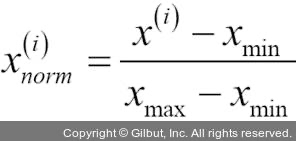

표준화 : 특성의 평균을 0에 맞추고, 표준 편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만든다.
- 표준화는 이상치 정보가 유지되기 때문에 제한된 범위로 데이터를 조정하는 min-max scaling에 비해 이상치에 덜 민감하다. 

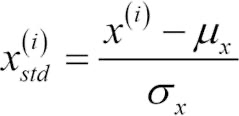

In [44]:
# min-max scaling을 사용한 특성의 스케일 조정 -> 정규화

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [45]:
# 표준화와 정규화

ex = np.array([0, 1, 2, 3, 4, 5])
print('표준화:', (ex - ex.mean()) / ex.std())
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


In [46]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train) # X_train에 대해서만 학습 후 학습데이터와 테스트 데이터 변환 -> 같은 평균과 표준편차를 적용하기 위해서
X_test_std = stdsc.transform(X_test) 

In [47]:
# RobustScaler는 중간 값을 빼고 1사분위수와 3사분위수의 차이로 나누어 데이터의 스케일을 조정한다. 

from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.fit_transform(X_test)

In [48]:
print((ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25)))

[-1.  -0.6 -0.2  0.2  0.6  1. ]


## 4.5 유용한 특성 선택

In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, random_state=1) # 매개변수 C는 규제 파라미터의 역수
lr.fit(X_train_std, y_train)
print('정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

정확도: 1.0
테스트 정확도: 1.0


In [50]:
# 절편 확인 -> w0
# lr 객체를 다중 클래스 데이터셋에 적용하면 OvR 방식 사용
# 첫 번째 절편은 클래스 1을 나머지 클래스인 2,3과 구분하는 모델의 절편. 두번째 절편은 클래스 2를 나머지 클래스와 구분, 세번째 절편은 클래스 3을 나머지 클래스와 구분

lr.intercept_

array([-1.26392152, -1.21596534, -2.37040177])

In [51]:
# 각 클래스마다 특성에 대한 가중치(w) 확인 

lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

In [52]:
lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

In [53]:
lr.coef_[1]

array([-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
        0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
        1.23246414,  0.        , -2.23212696])

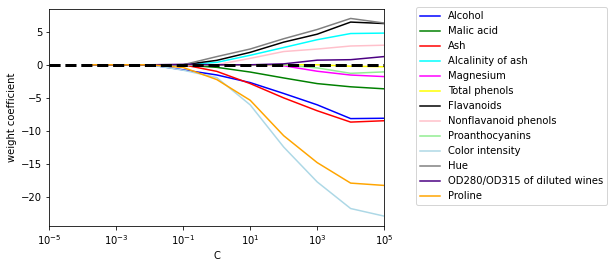

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 'pink', 
          'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []

for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
            label=df_wine.columns[column + 1],
            color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

규제 파라미터의 역수인 C가 작아질수록, 즉 규제의 강도가 커질수록 각 특성에 대한 가중치가 0으로 수렴한다.

### 4.5.4 순차 특성 선택 알고리즘

차원 축소 
1. 특성 선택 - 원본 특성에서 일부를 선택
2. 특성 추출 - 일련의 특성에서 얻은 정보로 새로운 특성을 만든다.

순차 특성 선택 알고리즘은 greedy search algorithm으로 초기 d차원의 특성 공간을 k < d인 k차원의 특성 부분 공간으로 축소한다. 
특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적이다.


Sequential Backward Selection(SBS) 
- SBS는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거한다.
- 각 단계에서 어떤 특성을 제거할지 판단하기 위해 최대화할 기준 함수를 정의하고, 이 함수에서 계산하는 값은 어떤 특성을 제거하기 전후의 모델의 성능 차이다. 즉, 각 단계에서 제거했을 때 성능 손실이 최소가 되는 특성을 제거한다.

1. 알고리즘을 k = d로 초기화한다. d는 전체 특성 공간 Xd의 차원이다.
2. 조건 $ x^{-} = argmax J(X_{k} - x) $ 를 최대화하는 특성 $x^{-}$를 결정한다. (x는 $X_{k}의$ 의 원소)
3. 특성 집합에서 특성 $x^{-}$를 제거한다. 즉, $X_{k-1} := X_{k} - x^{-};k := k - 1 $
4. k가 목표하는 특성 개수가 되면 종료 아니면 2, 3단계 반복

In [55]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features # 목표 특성 개수
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        dim = X_train.shape[1] # X_train의 column 개수
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features: # 원하는 특성 개수에 도달할 때까지 
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1): 
                # n : 특성의 개수, r = 특성 - 1 -> nCr == nCn-1
                # n개의 특성 중에서 n - 1개의 특성을 고르는 조합 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p) 
                
            best = np.argmax(scores) # 차원을 1개 줄일 때마다 가장 높은 성능을 갖는 특성의 조합을 찾아서 self.subsets에 해당 조합을 담는다.
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train) # 선택된 조합의 특성으로만 학습 
        y_pred = self.estimator.predict(X_test[:, indices]) # 선택된 조합의 특성만 예측에 사용
        score = self.scoring(y_test, y_pred)
        return score

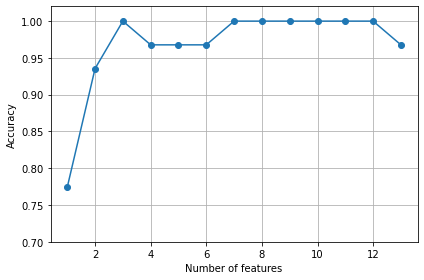

In [56]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [57]:
# 가장 작은 개수의 조합(k = 3)에서 높은 검증 성능을 내는 특성 확인
# 검증 성능이 높다 -> 데이터셋을 제대로 분류하기 위해서 중요한 특성이다. 

k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [58]:
# 전체 특성을 사용한 정확도

knn.fit(X_train_std, y_train)
print('정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [59]:
# 선택된 3개의 특성에 대한 정확도

knn.fit(X_train_std[:, k3], y_train)
print('정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


In [60]:
from sklearn.feature_selection import SequentialFeatureSelector

scores = []
for n_features in range(1, 13):
    sfs = SequentialFeatureSelector(knn, n_features_to_select=n_features, n_jobs=-1)
    sfs.fit(X_train_std, y_train)
    f_mask = sfs.support_
    knn.fit(X_train_std[:, f_mask], y_train)
    scores.append(knn.score(X_train_std[:, f_mask], y_train))

## 4.6 랜덤 포레스트의 특성 중요도 사용

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


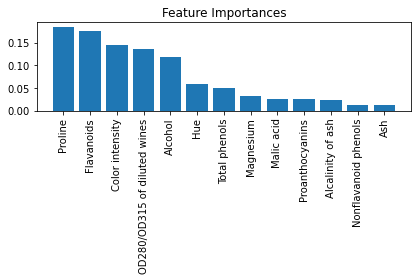

In [61]:
# wine 데이터셋 특성의 상대적인 중요도에 따른 순위 그래프

from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_ # 특성 중요도는 합이 1이되도록 정규화된 수치
indices = np.argsort(importances)[::-1] # 내림차순 정렬 인덱스
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [62]:
# 임계 값을 0.1로 하여 가장 중요한 5개의 특성 추출

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계조건을 만족하는 샘플의 수: ', X_selected.shape[1])

이 임계조건을 만족하는 샘플의 수:  5


In [63]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


### Note) RFE

- RFE는 재귀적 특성 제거 방법을 사용한다.
1. 처음에 모든 특성을 사용하여 모델을 만들고 특성 중요도가 가장 낮은 특성을 제거한다.
2. 그다음 제거된 특성을 빼고 나머지 특성으로 새로운 모델을 만든다.
3. 이런 식으로 미리 정의한 특성 개수가 남을 때까지 계속한다.

In [64]:
from sklearn.feature_selection import RFE
rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=1),
    n_features_to_select=5)

In [65]:
# ranking_ 속성에는 선택한 특성의 우선순위가 들어있다.

rfe.ranking_ # 1은 기반모델이 선택한 다섯 개의 특성

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

In [66]:
# 선택된 특성은 support_ 속성에 True로 표시된다. 이 값을 f_mask로 저장하여 특성의 이름을 표시하는데 사용

f_mask = rfe.support_

In [67]:
feat_labels[f_mask][4]

'Proline'

In [68]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f_mask][i], importances[i])) 
# formatting 의미
# print("%*s", parameter1, parameter2) - > parameter1으로 지정한 길이만큼의 공간에 parameter2 문자열을 출력
# '-' -> 왼쪽 정렬 
# so, %-*s 의미 : parameter1으로 지정한 길이만큼의 공간에 parameter2 문자열을 왼쪽 정렬하여 출력

 5) Proline                        0.261512
 5) Color intensity                0.216477
 5) Flavanoids                     0.212259
 5) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828


## 5.1 주성분 분석을 통한 비지도 차원 축소

- 특성선택과 특성 추출의 차이는 원본 특성을 유지하느냐에 따라 다르다.
- 특성선택 알고리즘은 원본 특성을 유지
- 특성 추출은 새로운 특성 공간으로 데이터를 변환 혹은 투영
- 특성 추출은 대부분의 관련 있는 정보를 유지하면서 데이터를 압축하는 방법

### 5.1.1 주성분 분석의 주요 단계

- PCA는 특성 사이의 상관관계르 기반으로 하여 데이터에 있는 어떤 패턴을 찾는다.
- 즉, PCA는 고차원 데이터에서 분산이 가장 큰 방향을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분 공간으로 이를 투영한다.
- 새로운 부분 공간의 직교 좌표(주성분)는 주어진 조건하에서 분산이 최대인 방향으로 해석할 수 있다.

PCA 사용 방법
1. d차원 데이터셋을 표준화 전처리
2. 공분산 행렬을 만든다.
3. 공분산 행렬을 고유 벡터와 고유값으로 분해
4. 고유값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매긴다.
5. 고유값이 가장 큰 k개의 고유 벡터를 선택한다. 여기서 k는 새로운 특성 부분 공간의 차원이다. (k <= d)
6. 최상위 k개의 고유 벡터로 투영 행렬 w를 만든다.
7. 투영 행렬 w를 사용해서 d차원 입력 데이터셋 x를 새로운 k차원의 특성 부분 공간으로 변환한다.

### 5.1.2 주성분 추출 단계

1. 데이터 표준화 전처리
2. 공분산 행렬 구성
3. 공분산 행렬의 고유값과 고유 벡터를 구한다.
4. 고유값을 내림차순으로 정렬하여 고유 벡터의 순위를 매긴다.

In [69]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [70]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 특성 표준화 전처리
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

- 공분산 행렬의 고유 벡터는 주성분(최대 분산의 방향)을 표현
- 이에 대응되는 고유값은 주성분의 크기
- wine 데이터셋의 경우 13 * 13 차원의 공분산 행렬로부터 13개의 고유 벡터와 고유값을 얻을 수 있다.

In [71]:
# linalg.eig 함수를 사용하여 wine 데이터셋의 공분산 행렬에 대한 고유벡터와 고유값 계산

import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고유값 \n%s' % eigen_vals)

# 13개의 고유값이 들어있는 벡터와 각 고유값에 대응하는 고유 벡터가 각 열에 저장된 13 * 13 차원의 행렬을 얻을 수 있다.


고유값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### 5.1.3 총 분산과 설명된 분산

- 데이터셋 차원을 새로운 특성 부분 공간으로 압축해서 줄여야 하기때문에 가장 많은 정보(분산)를 가진 고유벡터(주성분) 일부만 선택한다.

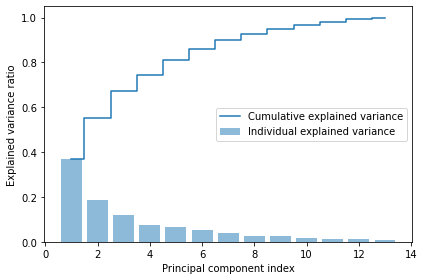

In [72]:
# 넘파이 cumsum 함수로 설명된 분산의 누적 합을 계산하고 step함수로 그래프 그리기

tot = sum(eigen_vals)
# sorted 함수는 파이썬 내장 함수로 본체 리스트는 내버려두고, 정렬한 새로운 리스트를 반환
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] # 설명된 분산 비율 리스트
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 5.1.4 특성 변환

In [73]:
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

In [74]:
# (고유값, 고유벡터) 튜플의 리스트를 만든다.
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# 내림차순으로 (고유값, 고유벡터) 튜플 정렬
eigen_pairs.sort(key=lambda k: k[0], reverse=True) 
# key = lambda k: k[0] -> 0번째 값인 고유값을 기준으로 정렬
# sort함수는 원래의 리스트를 정렬, key 매개변수에 입력된 값 혹은 함수를 기준으로 정렬

In [75]:
# 최상위 두 개의 고유 벡터로부터 13 * 2 차원의 투영 행렬 w를 만든다.

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis])) 
# hstack : 가로결합
# np.newaxis : 새로운 차원을 하나 만들어준다.
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [76]:
# 투영 행렬 w를 사용하여 샘플 x(13차원의 행 벡터)를 PCA 부분 공간(2개의 주성분)에 투영하여 x'를 얻을 수 있다.

X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [77]:
# 전체 124 * 13차원의 훈련 데이터셋을 행렬 점곱을 통해 2개의 주성분에 투영

X_train_pca = X_train_std.dot(w)

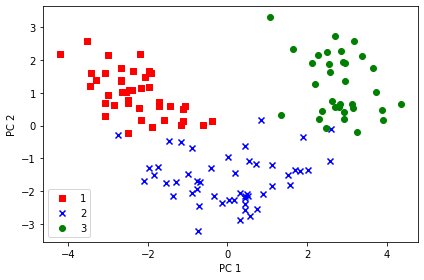

In [78]:
# 124 * 2차원의 행렬로 변환된 wine 훈련 데이터셋을 2차원 산점도로 시각화

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 5.1.5 사이킷런의 주성분 분석

- PCA 클래스는 변환기 클래스

In [79]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # 마커와 컬러맵 준비
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))]) # ListedColormap은 인자로 주어진 색상을 그래프상에 표시하기 위한 객체
    
    # 결정 경계를 그린다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # 클래스 샘플을 표시한다.
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    c=cmap.colors[idx],
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

/var/folders/0t/m5tmk07x1jn8mbwk5mpr748h0000gp/T/ipykernel_4242/2003179732.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


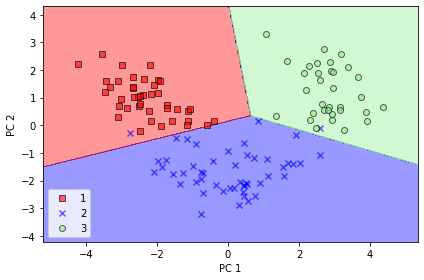

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# PCA 변환기와 로지스틱 회귀 추정기를 초기화
pca = PCA(n_components=2)
lr = LogisticRegression(random_state=1)

# 차원 축소
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# 축소된 데이터셋으로 로지스틱 회귀 모델 훈련
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

/var/folders/0t/m5tmk07x1jn8mbwk5mpr748h0000gp/T/ipykernel_4242/2003179732.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


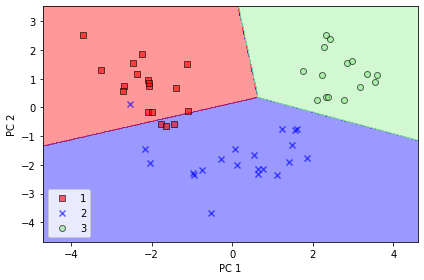

In [87]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [89]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std) # 차원 축소
pca.explained_variance_ratio_ # 설명된 분산 비율

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축

- 선형판별분석(Linear Discriminant Analysis, LDA)
- 규제가 없는 모델에서 과대적합 정도를 줄이고 계산 효율성을 높이기 위한 특성 추출의 기법으로 사용할 수 있다. 
- 지도학습
- LDA는 데이터가 정규 분포라고 가정, 또한 클래스가 동일한 공분산 행렬을 가지고 훈련 샘플은 서로 통계적으로 독립적이라고 가정

### 5.2.2 선형 판별 분석의 내부 동작 방식

LDA 수행에 필요한 주요 단계
1. d차원의 데이터셋을 표준화 전처리(d = 특성 개수)
2. 각 클래스에 대해 d차원의 평균 벡터를 계산
3. 클래스 간의 산포 행렬(scatter matrix)$S_{B}$와 클래스 내 산포 행렬 $S_{w}$를 구성
4. $S_{w}^{-1}S_{B}$ 행렬의 고유 벡터와 고유값을 계산
5. 고유값을 내림차순으로 정렬하여 고유 벡터의 순서를 매긴다.
6. 고유값이 가장 큰 k개의 고유 벡터를 선택하여 d * k차원의 변환 행렬 w를 구성한다. 이 행렬의 열이 고유 벡터이다.
7. 변환 행렬 w를 사용하여 샘플을 새로운 특성 부분 공간으로 투영

### 5.2.3 산포 행렬 계산

In [99]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0)) # 각 클래스 특성의 평균값이 평균 벡터가 된다.
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [100]:
# 클래스 내의 산포 행렬 계산

d = 13 # 특성 개수
S_W = np.zeros((d, d)) # (13, 13)차원의 0행렬 생성
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('클래스 내의 산포 행렬: %sx%s' %(S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 13x13


In [102]:
print('클래스 레이블 분포: %s' % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


산포 행렬을 계산할 때 훈련 데이터셋의 클래스 레이블이 균등하게 분포되어 있다고 가정하지만, 실제로 클래스 레이블의 개수를 확인해보면 이 가정이 틀렸음을 알 수 있다.

산포 행렬을 샘플 개수로 나누면 공분산 행렬을 계산하는 것과 같아진다.
- 공분산 행렬은 산포 행렬의 정규화 버전

In [103]:
d = 13 # 특성 개수
S_W = np.zeros((d, d)) # (13, 13)차원의 0행렬 생성
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' %(S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


In [105]:
# 클래스 간의 산포 행렬 계산

mean_overall = np.mean(X_train_std, axis=0) # 전체 평균
mean_overall = mean_overall.reshape(d, 1) # 열 벡터로 만들기
d = 13 # 특성 개수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0] # 데이터 개수
    mean_vec = mean_vec.reshape(d, 1) # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 13x13
